<a href="https://colab.research.google.com/github/Nickcys/hw3_M11221055/blob/main/%E3%80%8CU_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch

print("✅ CUDA 啟用：", torch.cuda.is_available())
if torch.cuda.is_available():
    print("🎯 使用 GPU：", torch.cuda.get_device_name(0))
else:
    print("❌ 還是跑在 CPU，請確認環境或重啟 Notebook")

✅ CUDA 啟用： True
🎯 使用 GPU： NVIDIA GeForce RTX 4060 Laptop GPU


1.導入套件

In [ ]:
pip install torch torchvision torchaudio

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader,TensorDataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import random

2.讀圖＋顯示影像資料

共讀取影像：287 筆
每張影像 shape: torch.Size([1, 256, 256]), 遮罩 shape: torch.Size([1, 256, 256])


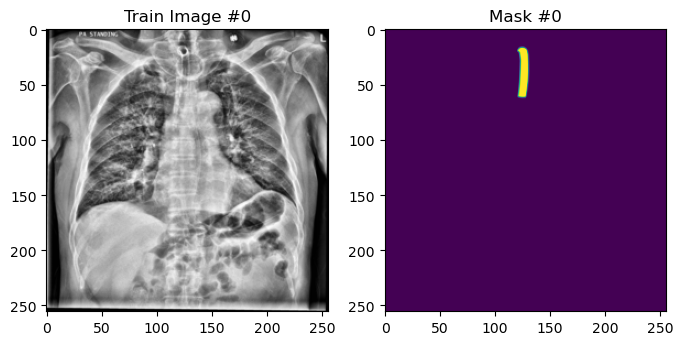

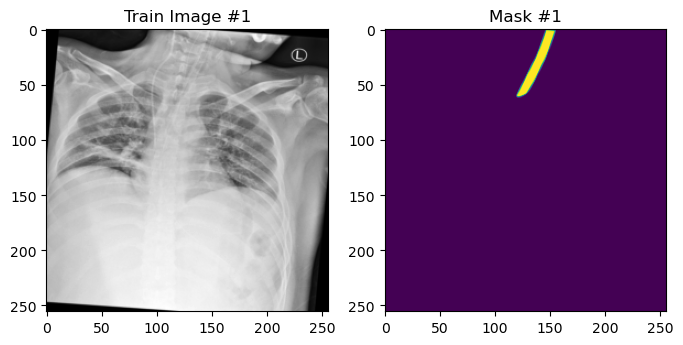

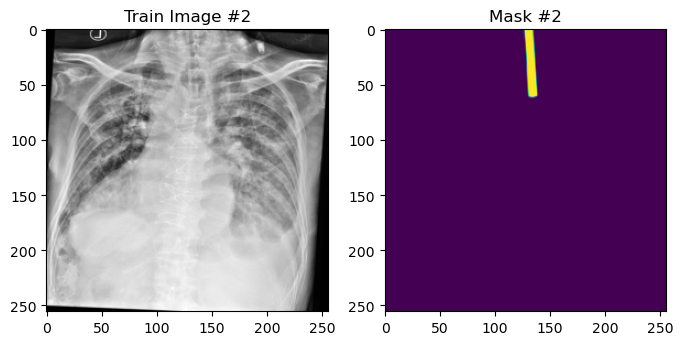

In [ ]:
# ========== 損失函數：Dice + BCE ==========
class DiceBCELoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceBCELoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.smooth = smooth

    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        return bce_loss + dice_loss
# ----------- Dataset 類別（使用 OpenCV 實作資料增強）-----------
class ETTDataset(Dataset):
    def __init__(self, img_dir, mask_dir, size=(256, 256), augment=False):
        valid_exts = ('.png', '.jpg', '.jpeg')
        self.img_list = sorted([f for f in os.listdir(img_dir) if f.lower().endswith(valid_exts)])
        self.mask_list = sorted([f for f in os.listdir(mask_dir) if f.lower().endswith(valid_exts)])
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.size = size
        self.augment = augment
        self.to_tensor = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(size),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_list[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_list[idx])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.augment:
            if random.random() > 0.5:
                img = cv2.flip(img, 1)
                mask = cv2.flip(mask, 1)
            if random.random() > 0.5:
                angle = random.uniform(-5, 5)
                M = cv2.getRotationMatrix2D((img.shape[1]//2, img.shape[0]//2), angle, 1.0)
                img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
                mask = cv2.warpAffine(mask, M, (mask.shape[1], mask.shape[0]), flags=cv2.INTER_NEAREST)

        mask = mask / 255.0
        return self.to_tensor(img), self.to_tensor(mask.astype(np.float32))

# ----------- 建立訓練資料集 & DataLoader -----------
train_dataset = ETTDataset("./Fold1/train", "./Fold1/trainannot", augment=True)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
print(f"共讀取影像：{len(train_dataset)} 筆")
img, mask = train_dataset[0]
print(f"每張影像 shape: {img.shape}, 遮罩 shape: {mask.shape}")
# ----------- 前3張圖視覺化檢查 -----------
for i in range(3):
    img, mask = train_dataset[i]
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f'Train Image #{i}')
    plt.subplot(1, 2, 2)
    plt.imshow(mask.squeeze(), cmap='viridis')
    plt.title(f'Mask #{i}')
    plt.show()


3.UNet 模型與工具函數

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        def CBR(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, 3, padding=1),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )
        self.enc1 = CBR(1, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)
        self.pool = nn.MaxPool2d(2)
        self.bottleneck = CBR(512, 1024)
        self.up4 = nn.ConvTranspose2d(1024, 512, 2, 2)
        self.dec4 = CBR(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, 2)
        self.dec3 = CBR(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, 2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, 2)
        self.dec1 = CBR(128, 64)
        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        b = self.bottleneck(self.pool(e4))
        d4 = self.dec4(torch.cat([self.up4(b), e4], 1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], 1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], 1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], 1))
        return self.final(d1)  # 輸出 logits，不做 activation

4.訓練與訓練集預測顯示

In [ ]:
train_dataset = ETTDataset("./Fold1/train", "./Fold1/trainannot", augment=True)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

# === GPU 裝置設定 & 建立模型 ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = DiceBCELoss()

epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"[Epoch {epoch+1}/{epochs}] Loss: {total_loss / len(train_loader):.4f}")

[Epoch 1/10] Loss: 1.2062
[Epoch 2/10] Loss: 0.9295
[Epoch 3/10] Loss: 0.5646
[Epoch 4/10] Loss: 0.4147
[Epoch 5/10] Loss: 0.3754
[Epoch 6/10] Loss: 0.3345
[Epoch 7/10] Loss: 0.3119
[Epoch 8/10] Loss: 0.2861
[Epoch 9/10] Loss: 0.2989
[Epoch 10/10] Loss: 0.2861


5.使用IOU指標評估模型並建立標記插管端點

In [ ]:
def calc_iou(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    intersection = (pred_bin * target).sum()
    union = ((pred_bin + target) > 0).float().sum()
    return (intersection / union).item() if union != 0 else 1.0

def extract_endpoint_y(mask_tensor):
    mask_bin = (mask_tensor > 0.5).float()
    y_coords = torch.nonzero(mask_bin.squeeze(), as_tuple=False)
    if y_coords.numel() == 0:
        return -1
    return y_coords[:, 0].max().item()

def compute_point_error_metrics(Y_pred_list, Y_true_list, pixel_per_cm=72):
    errors_cm = [abs(p - t) / pixel_per_cm for p, t in zip(Y_pred_list, Y_true_list)]
    mean_error = sum(errors_cm) / len(errors_cm)
    acc_05 = sum(e <= 0.5 for e in errors_cm) / len(errors_cm) * 100
    acc_10 = sum(e <= 1.0 for e in errors_cm) / len(errors_cm) * 100
    print(" 端點誤差評估：")
    print(f" 平均誤差：{mean_error:.4f} 公分")
    print(f" ≤0.5cm 準確率：{acc_05:.2f}%")
    print(f"≤1.0cm 準確率：{acc_10:.2f}%")

def evaluate_model_endpoint_prediction(model, dataset, device):
    model.eval()
    Y_pred_list, Y_true_list = [], []
    for i in range(len(dataset)):
        x, y = dataset[i]
        x = x.unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(x).cpu().squeeze(0)
        y_pred = extract_endpoint_y(pred)
        y_true = extract_endpoint_y(y)
        if y_pred != -1 and y_true != -1:
            Y_pred_list.append(y_pred)
            Y_true_list.append(y_true)
    return compute_point_error_metrics(Y_pred_list, Y_true_list)

def visualize_prediction(image_tensor, true_mask_tensor, pred_mask_tensor, threshold=0.5):
    img = image_tensor.squeeze().cpu().numpy()
    true_mask = true_mask_tensor.squeeze().cpu().numpy()
    pred_mask = pred_mask_tensor.squeeze().cpu().numpy()
    pred_mask_bin = (pred_mask > threshold).astype(float)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Image")
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='viridis')
    plt.title("Ground Truth Mask")
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask_bin, cmap='plasma')
    plt.title("Predicted Mask")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def get_endpoint(mask_bin):
    coords = np.argwhere(mask_bin > 0)
    if coords.size == 0:
        return None
    y = coords[:, 0].max()
    x = coords[coords[:, 0] == y][:, 1].mean()
    return int(x), int(y)

def visualize_with_endpoints(image_tensor, true_mask_tensor, pred_mask_tensor, threshold=0.5):
    img = image_tensor.squeeze().cpu().numpy()
    true_mask = true_mask_tensor.squeeze().cpu().numpy()
    pred_mask = pred_mask_tensor.squeeze().cpu().numpy()
    true_bin = (true_mask > 0.5).astype(float)
    pred_bin = (pred_mask > threshold).astype(float)

    gt_point = get_endpoint(true_bin)
    pred_point = get_endpoint(pred_bin)

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(true_bin, cmap='viridis')
    if gt_point:
        plt.scatter(*gt_point, c='red', s=40)
        plt.text(gt_point[0]+2, gt_point[1], "G", color='red', fontsize=12)
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred_bin, cmap='plasma')
    if pred_point:
        plt.scatter(*pred_point, c='red', s=40)
        plt.text(pred_point[0]+2, pred_point[1], "Y", color='red', fontsize=12)
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def evaluate_model_iou(model, dataset, device, name="資料集"):
    model.eval()
    ious = []
    with torch.no_grad():
        for i in range(len(dataset)):
            x, y = dataset[i]
            x = x.unsqueeze(0).to(device)
            pred = torch.sigmoid(model(x)).cpu().squeeze(0)
            iou = calc_iou(pred, y)
            ious.append(iou)
    mean_iou = sum(ious) / len(ious)
    print(f" {name} IOU 平均值：{mean_iou:.4f}")

In [ ]:
evaluate_model_endpoint_prediction(model, train_dataset, device)
print("\n📐 訓練集 IOU：")
evaluate_model_iou(model, train_dataset, device, name="訓練集")

 端點誤差評估：
 平均誤差：0.1931 公分
 ≤0.5cm 準確率：91.64%
≤1.0cm 準確率：98.61%

📐 訓練集 IOU：
 訓練集 IOU 平均值：0.5154


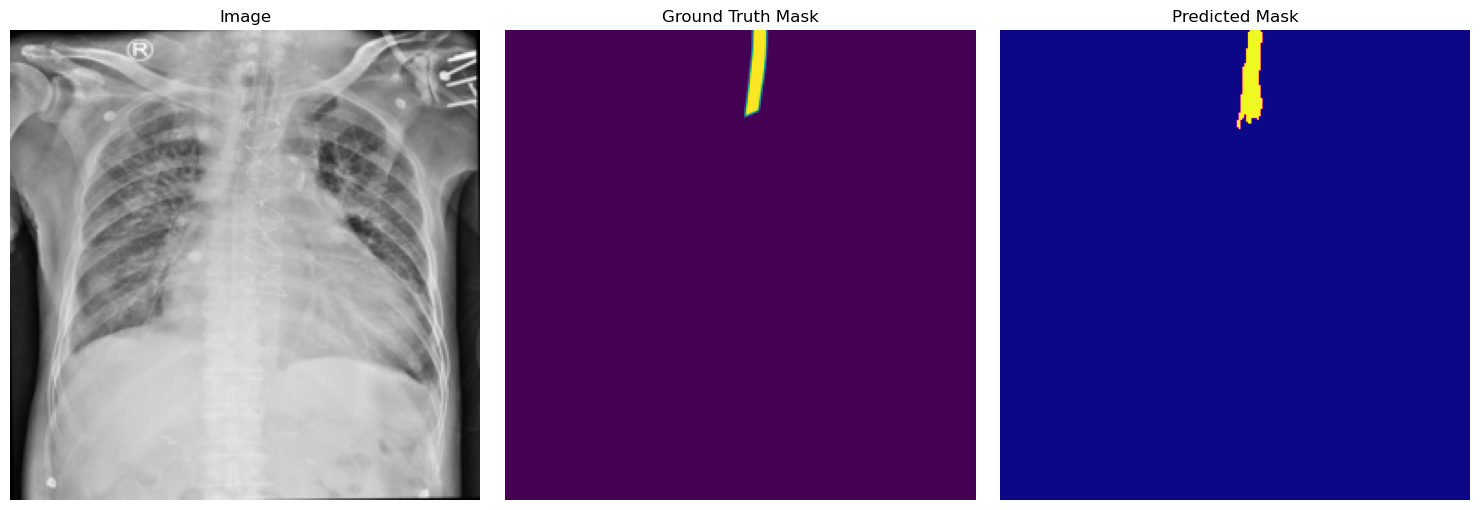

In [ ]:
# 預測與視覺化第69筆
model.eval()
with torch.no_grad():
    x, y = train_dataset[69]
    pred = model(x.unsqueeze(0).to(device)).cpu()
visualize_prediction(x, y, pred[0])

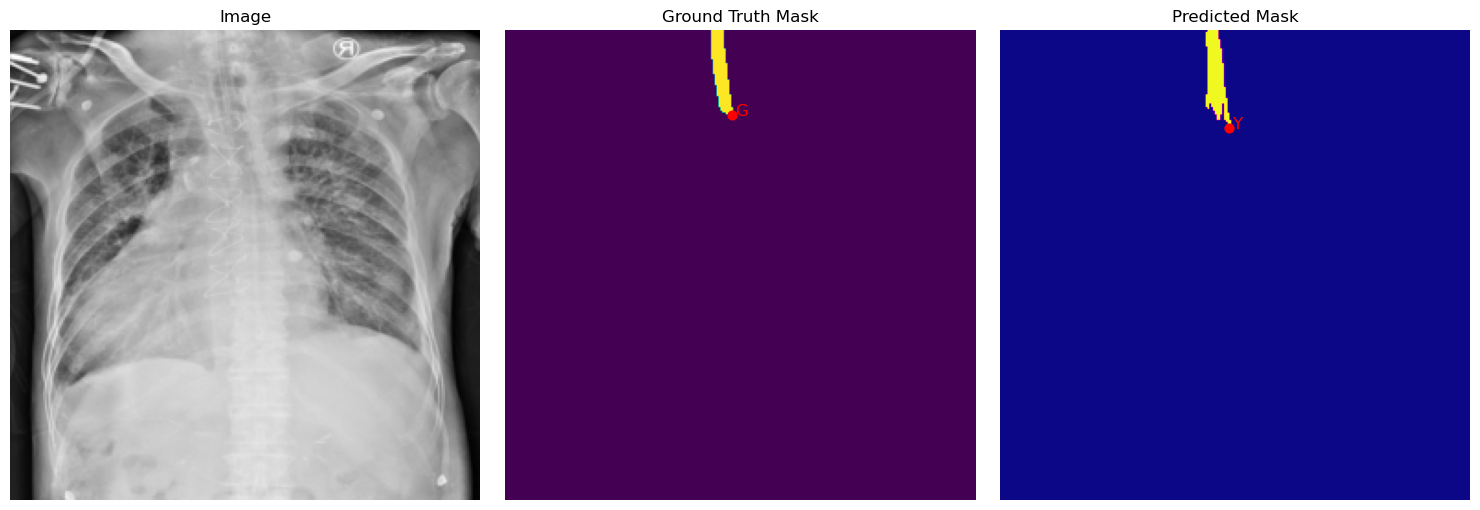

In [ ]:
# 預測與視覺化第69筆
with torch.no_grad():
    x, y = train_dataset[69]
    pred = model(x.unsqueeze(0).to(device)).cpu()

visualize_with_endpoints(x, y, pred[0])


導入驗證&測試資料

In [ ]:
val_dataset = ETTDataset("./Fold1/val", "./Fold1/valannot", augment=False)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_dataset = ETTDataset("./Fold1/test", "./Fold1/testannot", augment=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

驗證測試

In [ ]:
# === GPU 裝置設定 ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# === 建立模型 ===
model = UNet().to("cuda" if torch.cuda.is_available() else "cpu")
device = next(model.parameters()).device
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = DiceBCELoss()

# === 訓練 + 驗證流程 ===
best_val_iou = 0
best_model_path = "best_model_fold1.pth"
epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # 驗證流程
    model.eval()
    ious = []
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            pred_val = model(x_val)
            for i in range(len(x_val)):
                iou = calc_iou(torch.sigmoid(pred_val[i]).cpu(), y_val[i].cpu())
                ious.append(iou)
    val_iou = sum(ious) / len(ious)

    print(f"[Epoch {epoch+1}/{epochs}] Train Loss: {total_loss / len(train_loader):.4f}  Val IOU: {val_iou:.4f}")

    # 儲存最佳模型
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(model.state_dict(), best_model_path)

print("✅ 訓練完成，最佳模型已儲存。")

# === 測試流程：載入最佳模型並評估端點誤差 ===
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()
evaluate_model_endpoint_prediction(model, test_dataset, device)

[Epoch 1/10] Train Loss: 1.1603  Val IOU: 0.0645
[Epoch 2/10] Train Loss: 0.8237  Val IOU: 0.2392
[Epoch 3/10] Train Loss: 0.5088  Val IOU: 0.4223
[Epoch 4/10] Train Loss: 0.4080  Val IOU: 0.4276
[Epoch 5/10] Train Loss: 0.3519  Val IOU: 0.1021
[Epoch 6/10] Train Loss: 0.3223  Val IOU: 0.5321
[Epoch 7/10] Train Loss: 0.2953  Val IOU: 0.3847
[Epoch 8/10] Train Loss: 0.3185  Val IOU: 0.4412
[Epoch 9/10] Train Loss: 0.2961  Val IOU: 0.5346
[Epoch 10/10] Train Loss: 0.2651  Val IOU: 0.5484
✅ 訓練完成，最佳模型已儲存。


C:\Users\邱敬堯\AppData\Local\Temp\ipykernel_25204\2721620261.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path, map_locatio

 端點誤差評估：
 平均誤差：0.2181 公分
 ≤0.5cm 準確率：82.98%
≤1.0cm 準確率：95.74%


In [ ]:
print("\n📐 測試集 IOU：")
evaluate_model_iou(model, test_dataset, device, name="測試集")


📐 測試集 IOU：
 測試集 IOU 平均值：0.5522


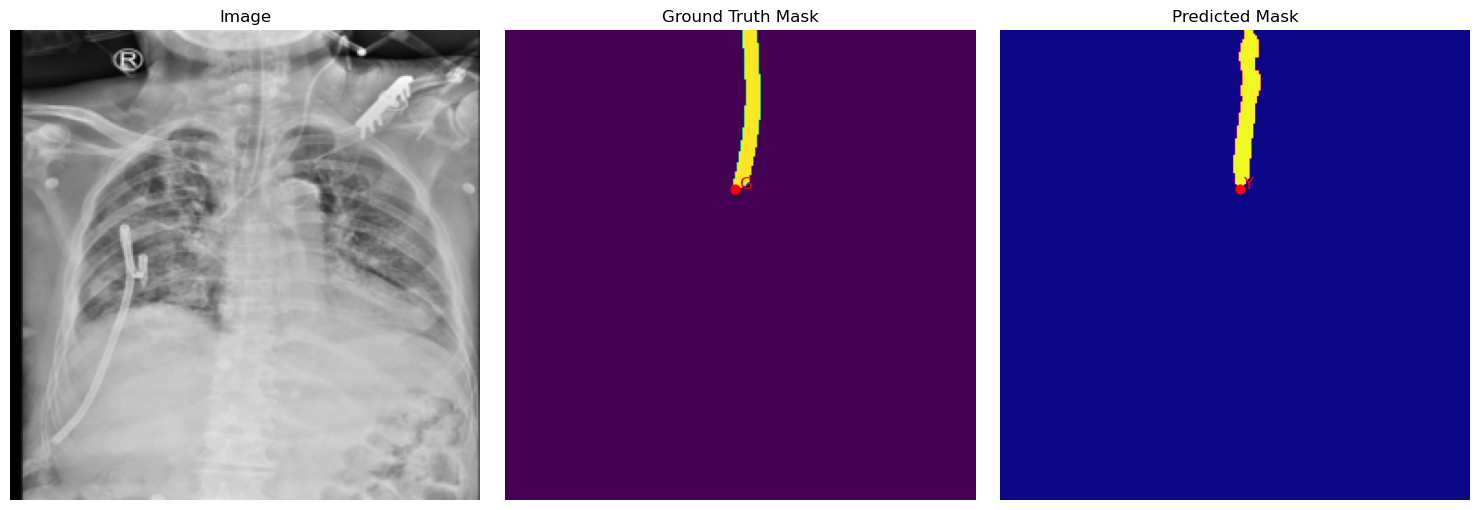

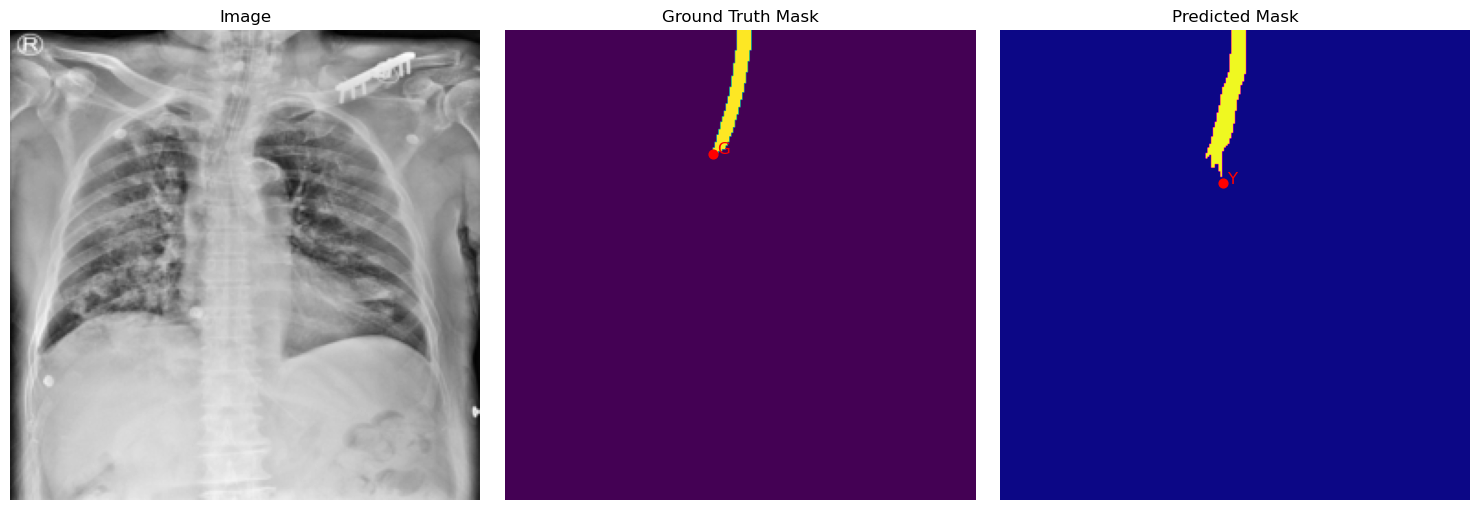

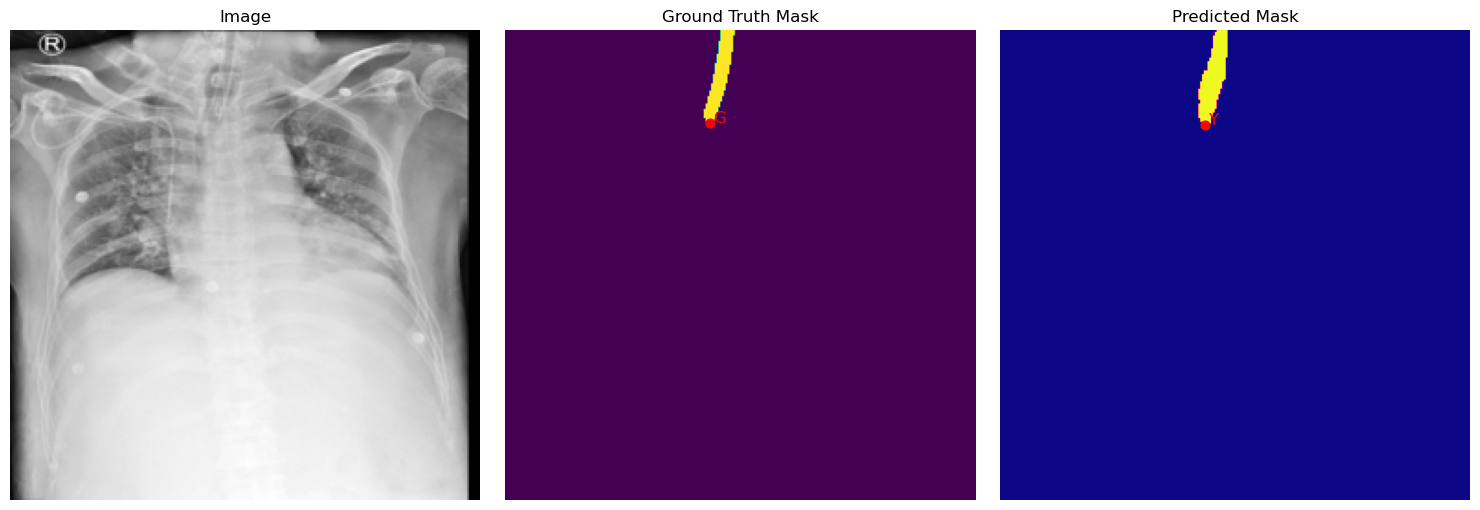

In [ ]:
# === 視覺化幾張測試影像 ===
for i in [7, 5, 12]:
    x, y = test_dataset[i]
    with torch.no_grad():
        pred = torch.sigmoid(model(x.unsqueeze(0).to(device))).cpu()
    visualize_with_endpoints(x, y, pred[0])